In [1]:
require('rstan')
require('tidyverse')
source("../mixture_model_scripts/test_code/project_utils.R")


Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.1     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.0
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

At

In [2]:
model1Sim <- function(N, p, Sigma){
    zeros <- c(0,0)

    # sample squared SEs
    se2 <- simSE2(N)

    ### SAMPLE BETAS FOR EACH MODEL
    # M0
    n.m0 <- floor(p[1]*N)
    se.m0 <- matrix(se2[1:(2*n.m0)], n.m0, 2)
    betas.m0 <- do.call(rbind, lapply(1:n.m0, function(x) mvrnorm(1, zeros, diag(se.m0[x,]))))

    # M1
    n.m1 <- N - n.m0
    se.m1 <- matrix(se2[(2*n.m0+1):(2*N)], n.m1, 2)
    betas.m1 <- do.call(rbind, lapply(1:n.m1, function(x) mvrnorm(1, zeros, diag(se.m1[x,])+Sigma)))

    # put together
    betas <- rbind(betas.m0, betas.m1)
    ses <- rbind(se.m0, se.m1)

    cov.data.sim <- list(
        N = N,
        M = 2,
        B = betas,
        SE = ses,
        K = 2
    )
    return(cov.data.sim)
}


In [3]:
N <- 1000 # number of samples
p <- c(0.5, 0.5) # fraction in each component (null, non-null)
S <- matrix(c(0.0012,0.0005, 0.0005, 0.0010),2,2)
fixS <- nearPD(S)$mat # nearest positive definite matrix
cov.data.M1.sim <- model1Sim(N, p, fixS)

In [29]:
head(cov.data.M1.sim$B)

[,1]          [,2]        
[1,]  0.0091354820  0.002921427
[2,]  0.0240111108 -0.034645727
[3,] -0.0000396624  0.012718491
[4,] -0.0043253014  0.005404966
[5,] -0.0985884878 -0.027911855
[6,] -0.0274276218 -0.072320116

In [5]:
start.time <- Sys.time()
# run stan to estimate the covariance
library(rstan)
options(warn=-1)
options(mc.cores = parallel::detectCores())
fit1_sim <- stan(
  file = "../mixture_model_scripts/models/model1_no_loglik.stan",  # Stan program
  data = cov.data.M1.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 200,          # number of warmup iterations per chain
  iter = 600,            # total number of iterations per chain
  cores = 4,              
  refresh = 200          # show progress every 'refresh' iterations
  )
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


Time difference of 1.444946 mins

In [25]:
simRun <- function(N, p_nn, S, simID){
    p <- c(1-p_nn, p_nn)
    
    fixS <- nearPD(S)$mat # nearest positive definite matrix
    cov.data.M1.sim <- model1Sim(N, p, fixS)
    fit1_sim <- stan(
      file = "../mixture_model_scripts/models/model1_no_loglik.stan",  # Stan program
      data = cov.data.M1.sim,    # named list of data
      chains = 4,             # number of Markov chains
      warmup = 200,          # number of warmup iterations per chain
      iter = 600,            # total number of iterations per chain
      cores = 4,              
      refresh = 200          # show progress every 'refresh' iterations
      )
    p.est <- getPi(fit1_sim)
    s.est <- getSigma(fit1_sim)
    
    # calculate posteriors
    B_dat <- cov.data.M1.sim$B
    SE_dat <- cov.data.M1.sim$SE

    N <- cov.data.M1.sim$N
    posteriors <- sapply(1:N, function(i) getPosterior2(B_dat[i,], SE_dat[i,], p.est, s.est))
    
    list.params <- list("p"=p_nn, "S"=fixS, "p.est"=p.est[[2]], "S.est"=s.est)
    save(posteriors, list.params, file=sprintf("../data/tmp_posteriors/sim/sim%s.RData", simID))
}

In [26]:
N <- 1000 # number of samples
S <- matrix(c(0.0012,0.0005, 0.0005, 0.0010),2,2)

simRes <- simRun(N, 0.8, S)

In [27]:
simRes

$p
[1] 0.8

$S
2 x 2 Matrix of class "dpoMatrix"
       [,1]  [,2]
[1,] 0.0012 5e-04
[2,] 0.0005 1e-03

$p.est
[1] 0.7859769

$S.est
            [,1]        [,2]
[1,] 0.001110560 0.000448642
[2,] 0.000448642 0.001079766


In [ ]:
# how do we estimate which fraction are assigned to the proper component?
getPosterior2 <- function(B, SE, p, Sigma){
        # get the posterior probability for a SNP

    zeros <- rep(0, length(SE)) #c(0,0)
    SE_mat <- diag(SE) #matrix(c(SE[1], 0, 0, SE[2]), 2, 2)
    p_1 = p[1]*dmnorm(B, zeros, SE_mat)
    p_2 = p[2]*dmnorm(B, zeros, SE_mat + Sigma)
    prob_1 = log(p_1) - log(p_1 + p_2)
    prob_2 = log(p_2) - log(p_1 + p_2)
    return(exp(prob_2))
}

posteriors <- sapply(1:N, function(i) getPosterior2(B_dat[i,], SE_dat[i,], p, Sigma))
 

In [28]:
# calculate the difference
covDatM1Sim

(p.est - p[2])**2/p[2]
mean(sum((s.est-fixS)**2/fixS))

(s.est-fixS)/fixS

ERROR: Error in eval(expr, envir, enclos): object 'covDatM1Sim' not found


In [9]:
# try a range of pi
range.pi <- seq(0.1, 0.9, 0.1)


In [8]:
# try a range of sigmasq
a <- runif(1, 0, 1)
b <- runif(1, 0, (1-a)/2)
c <- runif(1, 0, (1-a)/2)
d <- 1-a-b-c

samplePi <- function(){
    a <- runif(1, 0, 1)
    b <- runif(1, 0, (1-a)/2)
    c <- runif(1, 0, (1-a)/2)
    d <- 1-a-b-c
    return(c(d, b, c, a))
}

[1] 0.5402322

[1] 0.06141875

[1] 0.175165

[1] 0.2231841

In [ ]:
#### SIMULATIONS FOR M2

N <- 1000
p <- c(0.5, 0.2, 0.1, 0.2)
sigmasq <- c(0.005, 0.001, 0.002, 0.004) 
cov.data.M2.sim <- model2Sim(N, p, sigmasq)

In [9]:
#### What do I do with the simulated data?
simID <- "1_1"


In [11]:
list.params
head(posteriors)

Loading required package: Matrix


$p
[1] 0.1

$S
2 x 2 Matrix of class "dpoMatrix"
       [,1]  [,2]
[1,] 0.0023 3e-04
[2,] 0.0003 3e-04

$p.est
[1] 0.09463933

$S.est
             [,1]         [,2]
[1,] 0.0025457773 0.0003377431
[2,] 0.0003377431 0.0003072101


[1] 0.00917534 0.66518286 0.02308966 0.03529178 0.05735570 0.06475408

In [63]:
N <- 1000
getSumStats <- function(simID, cutoff){
    load(sprintf("../data/tmp_posteriors/sim/sim%s.RData", simID))
    cut <- N-(list.params$p*N)
    null.comp <- 1:cut
    non.null.comp <- cut:N
    null.corr <- sum(posteriors[null.comp]<cutoff)
    non.null.corr <- sum(posteriors[non.null.comp]>=cutoff)

    p.err <- abs(list.params$p-list.params$p.est) 
    s.mean.err <- mean(abs(list.params$S-list.params$S.est)) 
    return(data.frame(t(list("pi"=list.params$p, "cutoff"=cutoff, "pi_err"=p.err, 
                             "Sigma_me"=s.mean.err, "pct_null"=null.corr/cut, "pct_non"=non.null.corr/(N-cut)))))
}


In [64]:
sim_res <- do.call(rbind, 
                   lapply(1:9, function(x) do.call(rbind, 
                                                   lapply(1:10, function(y) do.call(rbind, 
                                                                                    lapply(seq(0.5, 0.9, 0.1), function(z) getSumStats(sprintf("%s_%s", x, y), z)))))))

In [66]:
require('tidyverse')
sim_res %>% head()
sim_res <- data.frame(apply(sim_res, c(1,2), as.numeric))

sim_res %>% summarize_all(mean, na.rm=TRUE)



pi  cutoff pi_err       Sigma_me     pct_null  pct_non
1 0.1 0.5    0.005360671  8.211837e-05 0.9944444 0.36   
2 0.1 0.6    0.005360671  8.211837e-05 0.9966667 0.34   
3 0.1 0.7    0.005360671  8.211837e-05 0.9988889 0.33   
4 0.1 0.8    0.005360671  8.211837e-05 0.9988889 0.31   
5 0.1 0.9    0.005360671  8.211837e-05 0.9988889 0.26   
6 0.1 0.5    0.0008510198 0.0003995539 0.9966667 0.56

pi  cutoff pi_err   Sigma_me     pct_null  pct_non  
1 0.5 0.7    0.015798 0.0001229868 0.8682794 0.5936241

In [67]:
sim_res %>% write_csv("../data/res_1028/sim_res_m1.csv")

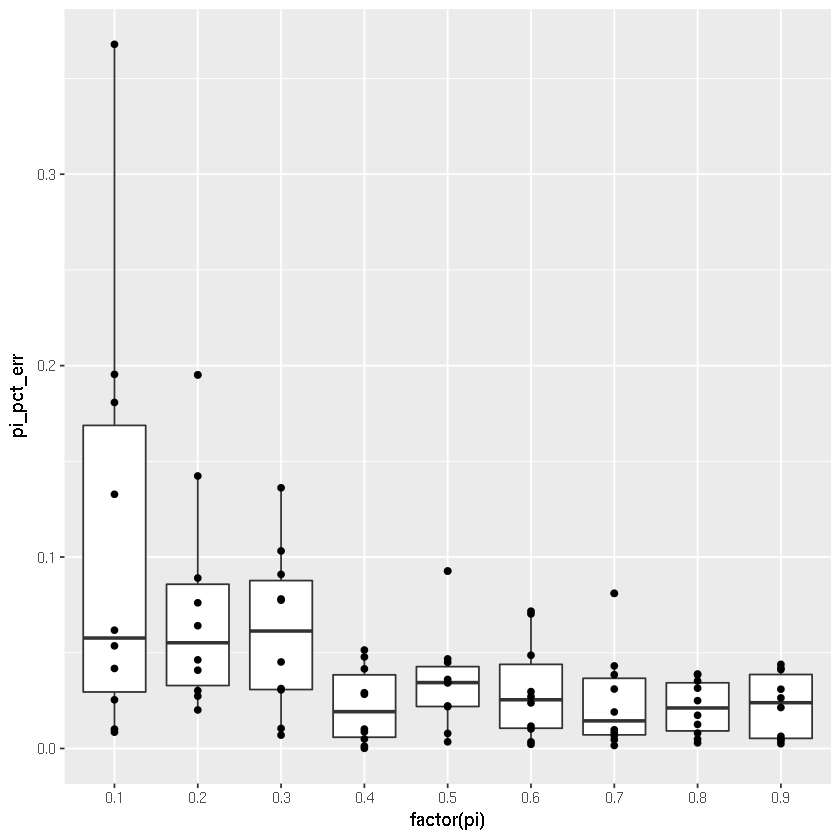

In [72]:
ggplot(sim_res %>% filter(cutoff==0.5), aes(x=factor(`pi`), y=pi_pct_err))+geom_boxplot()+geom_point()

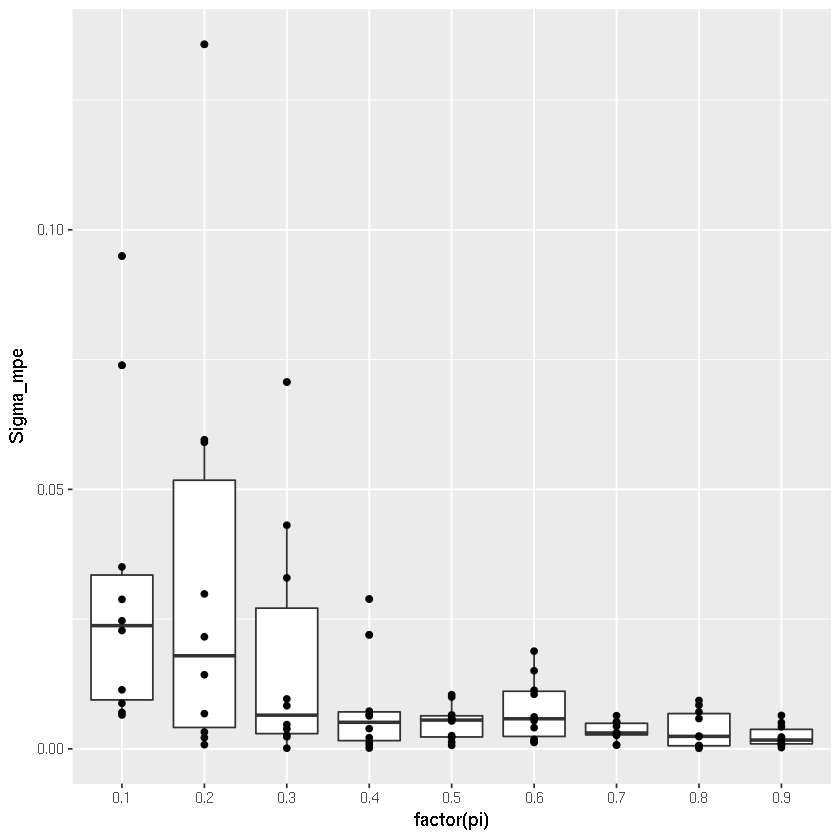

In [73]:
ggplot(sim_res %>% filter(cutoff==0.5), aes(x=factor(`pi`), y=Sigma_mpe))+geom_boxplot()+geom_point()


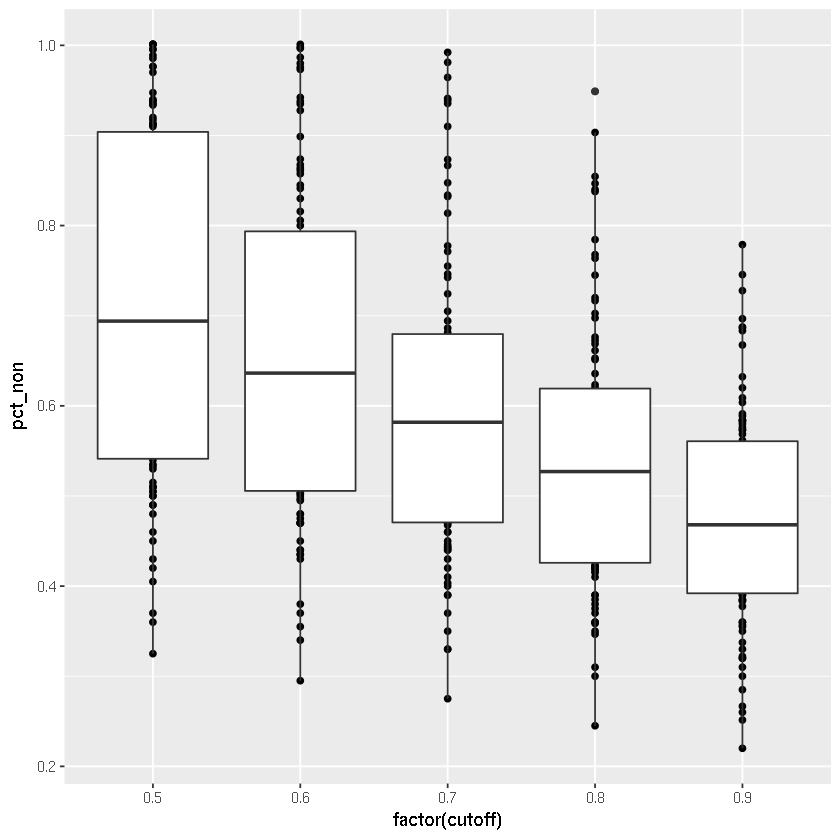

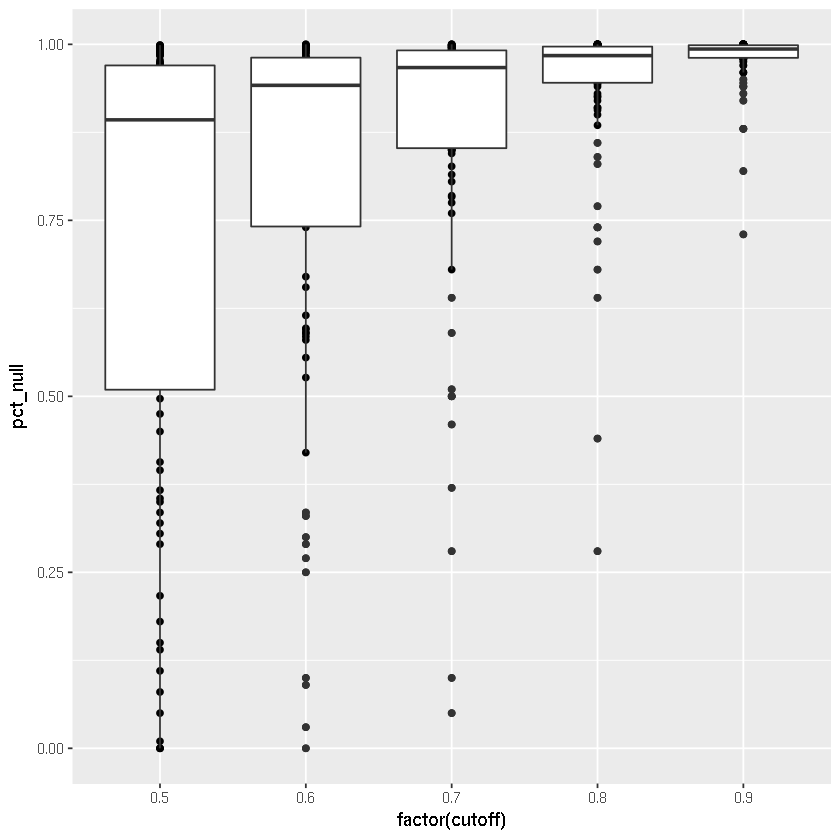

In [81]:
ggplot(sim_res, aes(x=factor(cutoff), y=pct_non))+geom_point()+geom_boxplot()
ggplot(sim_res, aes(x=factor(cutoff), y=pct_null))+geom_point()+geom_boxplot()

`geom_smooth()` using method = 'loess'


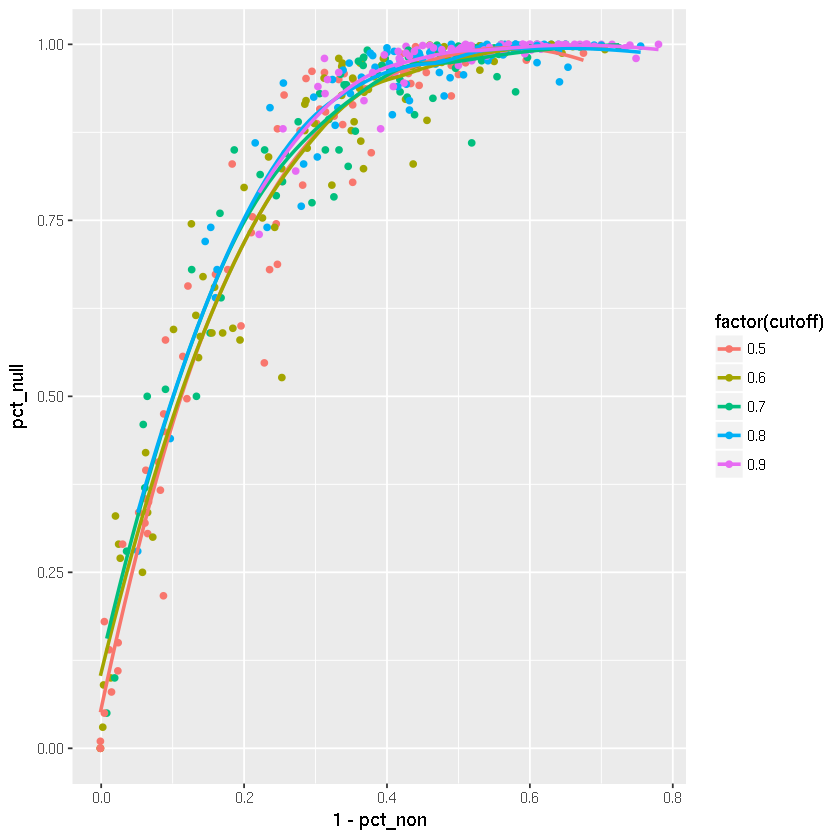

In [80]:
ggplot(sim_res, aes(y=pct_null, x=1-pct_non, group=factor(cutoff)))+geom_point(aes(color=factor(cutoff)))+
geom_smooth(se=FALSE, aes(color=factor(cutoff)))

#### FOR M2

In [3]:
simID <- c("1_9")
    load("../data/sim2_1028/m2sim_10_1.RData")
list.params

head(posterior.df)

$p
[1] 0.73344153 0.01633293 0.10654456 0.14368099

$s
[1] 0.05699738 0.07643455 0.06131674 0.06131674

$p.est
[1] 0.6858945891 0.1238277591 0.0003706958 0.1899069560

$sigmasq.est
[1] 0.035483276 7.007357668 0.016388701 0.009610405

X1        X2          X3           X4         
1 0.9929411 0.005897722 1.738897e-06 0.001159466
2 0.9528304 0.0219675   1.138342e-05 0.02519075 
3 0.5369297 0.1729391   9.97403e-06  0.2901212  
4 0.9883124 0.00655912  7.297655e-06 0.005121221
5 0.6301074 0.2442085   3.189962e-06 0.1256809  
6 0.6928787 0.1541409   6.735613e-06 0.1529736

In [ ]:
getSumStats <- function(simID, cutoff){

    cut <- N-(list.params$p*N)
    null.comp <- 1:cut
    non.null.comp <- cut:N
    null.corr <- sum(posteriors[null.comp]<cutoff)
    non.null.corr <- sum(posteriors[non.null.comp]>=cutoff)

    p.err <- abs(list.params$p-list.params$p.est) 
    s.mean.pct.err <- sum((list.params$S-list.params$S.est)**2)/(sum(list.params$S**2)) # mean percent error
    return(data.frame(t(list("pi"=list.params$p, "cutoff"=cutoff, "pi_pct_err"=p.pct.err, 
                             "Sigma_mpe"=s.mean.pct.err, "pct_null"=null.corr/cut, "pct_non"=non.null.corr/(N-cut)))))
}


In [41]:
N <- 3000
getSumStatsM2 <- function(simID, cutoff){
    res = tryCatch({
          load(sprintf("../data/sim2_1028/m2sim_%s.RData", simID))
  p <- list.params$p
    p.est<- list.params$p.est

    # look at vars
    p_err <- mean(abs(list.params$p-list.params$p.est))

    s1_err <- abs(list.params$sigmasq.est[[1]] - list.params$s[[1]])
    s2_err <- abs(list.params$sigmasq.est[[2]] - list.params$s[[2]])
    s3_err <- abs(list.params$sigmasq.est[[3]] - list.params$s[[3]])
    
    
    # figure out assignment
    n_p1 <- round(N*list.params$p[[1]])
    n_p2 <- round(N*list.params$p[[2]])
    n_p3 <- round(N*list.params$p[[3]])
    n_p4 <- N-(n_p1+n_p2+n_p3)

    p1_vars <- 1:n_p1
    p2_vars <- (n_p1+1):(n_p1+n_p2)
    p3_vars <- (n_p1+n_p2+1):(n_p1+n_p2+n_p3)
    p4_vars <- (n_p1+n_p2+n_p3+1):N
    colnames(posterior.df) <- c("p1", "p2", "p3", "p4")
    posterior.df2 <- posterior.df %>% mutate(category=case_when(
    p2 > cutoff ~ 2, p3 > cutoff ~ 3, p4 > cutoff ~ 4, TRUE ~ 1))
    
    # calculate the incorrect assignment for each
    p3_tp <- sum(posterior.df2[p3_vars,]$category==3)
    p3_fp <- sum(posterior.df2[!p3_vars,]$category==3)
    p3_fn <- sum(posterior.df2[p3_vars,]$category!=3)
    p4_tp <- sum(posterior.df2[p4_vars,]$category==4)
    p4_fp <- sum(posterior.df2[!p4_vars,]$category==4)
    p4_fn <- sum(posterior.df2[p4_vars,]$category!=4)
    p2_tp <- sum(posterior.df2[p2_vars,]$category==2)
    p2_fp <- sum(posterior.df2[!p2_vars,]$category==2)
    p2_fn <- sum(posterior.df2[p2_vars,]$category!=2)
    
    df <- data.frame(simID, cutoff, p[[1]], p[[2]], p[[3]], p[[4]], p.est[[1]], p.est[[2]], p.est[[3]], p.est[[4]], p2_tp, p2_fp, p2_fn, p3_tp, p3_fp, p3_fn, p4_tp, p4_fp, p4_fn)
        return(df)
    }, error = function(e) {
        print("file missing")
        df <- data.frame(simID, cutoff, t(unlist(rep(NA, 17))))
        colnames(df) <- my_cols
        return(df)
    })
    
    
}
 

In [40]:
my_cols <- colnames(getSumStatsM2("1_2", 0.8))

In [42]:
sim_res_m2 <- do.call(rbind, 
                   lapply(1:10, function(x) do.call(rbind, 
                                                   lapply(1:10, function(y) do.call(rbind, 
                                                                                    lapply(seq(0.5, 0.9, 0.1), function(z) getSumStatsM2(sprintf("%s_%s", x, y), z)))))))

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_1_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_2_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_2_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_2_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_2_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_2_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_3_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_4_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_5_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_6_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_7_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_7_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_7_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_7_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_7_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_2.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_2.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_2.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_2.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_2.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_3.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_3.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_3.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_3.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_3.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_4.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_4.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_4.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_4.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_4.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_5.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_5.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_5.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_5.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_5.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_6.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_6.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_6.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_6.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_6.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_7.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_7.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_7.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_7.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_7.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_8.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_9.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_8_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_9_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_9_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_9_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_9_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../data/sim2_1028/m2sim_9_10.RData', probable reason 'No such file or directory'”

[1] "file missing"


In [43]:
summary(sim_res_m2)

     simID         cutoff        p..1..           p..2..       
 1_1    :  5   Min.   :0.5   Min.   :0.5052   Min.   :0.00402  
 1_2    :  5   1st Qu.:0.6   1st Qu.:0.5525   1st Qu.:0.01772  
 1_3    :  5   Median :0.7   Median :0.5934   Median :0.05403  
 1_4    :  5   Mean   :0.7   Mean   :0.6167   Mean   :0.06895  
 1_5    :  5   3rd Qu.:0.8   3rd Qu.:0.6664   3rd Qu.:0.11328  
 1_6    :  5   Max.   :0.9   Max.   :0.8271   Max.   :0.21954  
 (Other):470                 NA's   :130      NA's   :130      
     p..3..            p..4..          p.est..1..       p.est..2..     
 Min.   :0.00297   Min.   :0.00076   Min.   :0.3822   Min.   :0.00034  
 1st Qu.:0.01991   1st Qu.:0.12229   1st Qu.:0.5037   1st Qu.:0.00037  
 Median :0.04960   Median :0.24473   Median :0.5523   Median :0.00041  
 Mean   :0.06820   Mean   :0.24620   Mean   :0.5690   Mean   :0.04834  
 3rd Qu.:0.09980   3rd Qu.:0.36883   3rd Qu.:0.6243   3rd Qu.:0.08568  
 Max.   :0.21635   Max.   :0.48322   Max.   :0.8065   Ma

In [44]:
write_csv(sim_res_m2, "../data/res_1028/sim_res_m2v2.csv")


In [24]:
colnames(posterior.df) <- c("p1", "p2", "p3", "p4")
cutoff <- 0.8
posterior.df2 <- posterior.df %>% mutate(category=case_when(
    p2 > cutoff ~ 2, p3 > cutoff ~ 3, p4 > cutoff ~ 4, TRUE ~ 1))

In [47]:
# calculate the incorrect fraction for each?

p3_tp <- sum(posterior.df2[p3_vars,]$category==3)
p3_fp <- sum(posterior.df2[!p3_vars,]$category==3)
p3_fn <- sum(posterior.df2[p3_vars,]$category!=3)


p4_tp <- sum(posterior.df2[p4_vars,]$category==4)
p4_fp <- sum(posterior.df2[!p4_vars,]$category==4)
p4_fn <- sum(posterior.df2[p4_vars,]$category!=4)


p2_tp <- sum(posterior.df2[p2_vars,]$category==2)
p2_fp <- sum(posterior.df2[!p2_vars,]$category==2)
p2_fn <- sum(posterior.df2[p2_vars,]$category!=2)



ERROR: Error in parse(text = x, srcfile = src): <text>:17:6: unexpected ','
16: 
17: p2_tp,
         ^


In [46]:
p_err <- mean(abs(list.params$p-list.params$p.est))

s1_err <- abs(list.params$sigmasq.est[[1]] - list.params$s[[1]])
s2_err <- abs(list.params$sigmasq.est[[2]] - list.params$s[[2]])
s3_err <- abs(list.params$sigmasq.est[[3]] - list.params$s[[3]])

s1_err
s2_err
s3_err

[1] 5.651434

[1] 0.03270862

[1] 0.0002446327

In [50]:
df <- data.frame(simID, cutoff, p_err, s1_err, s2_err, s3_err, p2_tp, p2_fp, p2_fn, p3_tp, p3_fp, p3_fn, p4_tp, p4_fp, p4_fn)
df

simID cutoff p_err       s1_err   s2_err     s3_err       p2_tp p2_fp p2_fn
1 1_1   0.8    0.002059371 5.651434 0.03270862 0.0002446327 0     0     12   
  p3_tp p3_fp p3_fn p4_tp p4_fp p4_fn
1 7     0     106   878   0     200